# Vision Transformer (ViT) for MNIST

In this notebook, we test a ViT implementation with MNIST dataset.

In [1]:
import torch
import torchvision
# vit-pytorch
from vit_pytorch import ViT
#
import numpy as np
#
import tqdm
import time
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the MNIST dataset

In [2]:
torch.manual_seed(42)

DOWNLOAD_PATH = "./data/mnist"
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST  = 100

transform = torchvision.transforms.ToTensor()
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
#                                             torchvision.transforms.Normalize([0.1307,], [0.3081,])])

# Dataset
train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform)
test_set  = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                       transform=transform)
# Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=BATCH_SIZE_TEST,  shuffle=True)

## Training and Evaluation Functions

In [3]:
# Traning functino for one epoch
def train_epoch(model, optimizer, loss_fn, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    
    model.train() # Enter the training mode
    
    train_loss = 0
    
    pbar = tqdm.tqdm(data_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        # Update the train_loss
        train_loss = 1./(batch_idx+1) * (batch_idx*train_loss + loss.data.item())
        # Display
        pbar.set_description("Current training loss %.4f" % train_loss)
        
        if batch_idx % 100 == 0:
            loss_history.append(loss.item())
    
    print(f'\nAverage training loss: {train_loss :.4f}')

In [4]:
# Evaluation function
def evaluate(model, loss_fn, data_loader, loss_history):
    model.eval() # Enter the evaluation mode
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    test_loss = 0
    
    with torch.no_grad():
        pbar = tqdm.tqdm(data_loader)
        for batch_idx, (data, target) in enumerate(pbar):
            output = model(data)
            # Analyze the result
            loss = loss_fn(output, target) # The loss
            _, pred = torch.max(output, dim=1) # The predicted class
            
            # Update the train_loss
            test_loss = 1./(batch_idx+1) * (batch_idx*test_loss + loss.data.item())
            # Display
            pbar.set_description("Current training loss %.4f" % test_loss)
            # Accumulate
            correct_samples += pred.eq(target).sum()
            
    
    loss_history.append(test_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(test_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

## Generate the Model (ViT) and Train

A ViT model

In [5]:
# Instantiate a model
model_vit = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=18, depth=2, heads=2, mlp_dim=25)
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=0.003)
loss_fn_vit = torch.nn.CrossEntropyLoss()
#
# print(model_vit)

In [6]:
# # Instantiate a model
# model_vit = ViT(image_size=28, patch_size=4, num_classes=10, channels=1,
#             dim=18, depth=6, heads=2, mlp_dim=25)
# optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=0.003)
# loss_fn_vit = torch.nn.CrossEntropyLoss()
# #
# # print(model_vit)

A simple CNN model

In [7]:
from torch import nn
import torch.nn.functional as F
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x)
        return x # directly output the score

In [8]:
# Instantiate a model
model_cnn = CNNnet()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.003)
loss_fn_cnn = torch.nn.CrossEntropyLoss()

## Model Size

The tool for measuring the model size

In [9]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    # The total size
    total_size = param_size + buffer_size
    # The scaling for display
    if total_size >= 1024**2:
        size_level = 'MB'
        size_scale = 1.0/1024**2
    else:
        size_level = 'kB'
        size_scale = 1.0/1024
    print('='*30)
    print(f'model paramater size: {(param_size*size_scale) :.3f}{size_level}')
    print(f'model buffer size: {(buffer_size*size_scale) :.3f}{size_level}')
    print('-'*30)
    print(f'model buffer size: {(total_size*size_scale) :.3f}{size_level}')
    print('='*30)

Check the model sizes

In [10]:
get_model_size(model_vit)

model paramater size: 85.734kB
model buffer size: 0.000kB
------------------------------
model buffer size: 85.734kB


In [11]:
get_model_size(model_cnn)

model paramater size: 85.312kB
model buffer size: 0.000kB
------------------------------
model buffer size: 85.312kB


## Train the Mode

In [12]:
def train_loop(model, optimizer, loss_fn, train_loader, test_loader, n_epochs=10):
    start_time = time.time()
    train_loss_history, test_loss_history = list(), list()
    for epoch in range(1, n_epochs+1):
        print('EPOCH:', epoch)
        train_epoch(model, optimizer, loss_fn, train_loader, train_loss_history)
        evaluate(model, loss_fn, test_loader, test_loss_history)

    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    return model

The ViT model

In [13]:
train_loop(model_vit, optimizer_vit, loss_fn_vit, train_loader, test_loader, n_epochs=10)

EPOCH: 1


Current training loss 0.7678: 100%|██████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.94it/s]



Average training loss: 0.7678


Current training loss 0.5481: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.83it/s]



Average test loss: 0.5481  Accuracy: 8051/10000 (80.51%)

EPOCH: 2


Current training loss 0.5029: 100%|██████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.85it/s]



Average training loss: 0.5029


Current training loss 0.4772: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.58it/s]



Average test loss: 0.4772  Accuracy: 8280/10000 (82.80%)

EPOCH: 3


Current training loss 0.4598: 100%|██████████████████████████████████████████████████| 600/600 [00:31<00:00, 19.06it/s]



Average training loss: 0.4598


Current training loss 0.4594: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.30it/s]



Average test loss: 0.4594  Accuracy: 8337/10000 (83.37%)

EPOCH: 4


Current training loss 0.4361: 100%|██████████████████████████████████████████████████| 600/600 [00:33<00:00, 17.87it/s]



Average training loss: 0.4361


Current training loss 0.4787: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.28it/s]



Average test loss: 0.4787  Accuracy: 8292/10000 (82.92%)

EPOCH: 5


Current training loss 0.4197: 100%|██████████████████████████████████████████████████| 600/600 [00:33<00:00, 17.83it/s]



Average training loss: 0.4197


Current training loss 0.4387: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.61it/s]



Average test loss: 0.4387  Accuracy: 8421/10000 (84.21%)

EPOCH: 6


Current training loss 0.4092: 100%|██████████████████████████████████████████████████| 600/600 [00:31<00:00, 19.30it/s]



Average training loss: 0.4092


Current training loss 0.4358: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.91it/s]



Average test loss: 0.4358  Accuracy: 8440/10000 (84.40%)

EPOCH: 7


Current training loss 0.3977: 100%|██████████████████████████████████████████████████| 600/600 [00:31<00:00, 18.97it/s]



Average training loss: 0.3977


Current training loss 0.4147: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.59it/s]



Average test loss: 0.4147  Accuracy: 8478/10000 (84.78%)

EPOCH: 8


Current training loss 0.3899: 100%|██████████████████████████████████████████████████| 600/600 [00:31<00:00, 18.77it/s]



Average training loss: 0.3899


Current training loss 0.4138: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.56it/s]



Average test loss: 0.4138  Accuracy: 8497/10000 (84.97%)

EPOCH: 9


Current training loss 0.3833: 100%|██████████████████████████████████████████████████| 600/600 [00:31<00:00, 19.30it/s]



Average training loss: 0.3833


Current training loss 0.4400: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.50it/s]



Average test loss: 0.4400  Accuracy: 8421/10000 (84.21%)

EPOCH: 10


Current training loss 0.3783: 100%|██████████████████████████████████████████████████| 600/600 [00:32<00:00, 18.65it/s]



Average training loss: 0.3783


Current training loss 0.4185: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.31it/s]


Average test loss: 0.4185  Accuracy: 8491/10000 (84.91%)

Execution time: 349.26 seconds


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=18, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=18, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=18, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=18, out_features=25, bias=True)
 

The CNN model

In [14]:
train_loop(model_cnn, optimizer_cnn, loss_fn_cnn, train_loader, test_loader, n_epochs=10)

EPOCH: 1


Current training loss 0.8813: 100%|██████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.93it/s]



Average training loss: 0.8813


Current training loss 0.5213: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.17it/s]



Average test loss: 0.5213  Accuracy: 7930/10000 (79.30%)

EPOCH: 2


Current training loss 0.6352: 100%|██████████████████████████████████████████████████| 600/600 [00:24<00:00, 24.56it/s]



Average training loss: 0.6352


Current training loss 0.4536: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.62it/s]



Average test loss: 0.4536  Accuracy: 8309/10000 (83.09%)

EPOCH: 3


Current training loss 0.5739: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.41it/s]



Average training loss: 0.5739


Current training loss 0.4161: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.22it/s]



Average test loss: 0.4161  Accuracy: 8434/10000 (84.34%)

EPOCH: 4


Current training loss 0.5348: 100%|██████████████████████████████████████████████████| 600/600 [00:24<00:00, 24.04it/s]



Average training loss: 0.5348


Current training loss 0.3997: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.67it/s]



Average test loss: 0.3997  Accuracy: 8472/10000 (84.72%)

EPOCH: 5


Current training loss 0.5120: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.65it/s]



Average training loss: 0.5120


Current training loss 0.3767: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.15it/s]



Average test loss: 0.3767  Accuracy: 8576/10000 (85.76%)

EPOCH: 6


Current training loss 0.5006: 100%|██████████████████████████████████████████████████| 600/600 [00:25<00:00, 23.56it/s]



Average training loss: 0.5006


Current training loss 0.3775: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.86it/s]



Average test loss: 0.3775  Accuracy: 8599/10000 (85.99%)

EPOCH: 7


Current training loss 0.4849: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.30it/s]



Average training loss: 0.4849


Current training loss 0.3672: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.73it/s]



Average test loss: 0.3672  Accuracy: 8631/10000 (86.31%)

EPOCH: 8


Current training loss 0.4780: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.79it/s]



Average training loss: 0.4780


Current training loss 0.3617: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.18it/s]



Average test loss: 0.3617  Accuracy: 8630/10000 (86.30%)

EPOCH: 9


Current training loss 0.4758: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.95it/s]



Average training loss: 0.4758


Current training loss 0.3652: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.84it/s]



Average test loss: 0.3652  Accuracy: 8656/10000 (86.56%)

EPOCH: 10


Current training loss 0.4712: 100%|██████████████████████████████████████████████████| 600/600 [00:23<00:00, 26.03it/s]



Average training loss: 0.4712


Current training loss 0.3524: 100%|██████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.96it/s]


Average test loss: 0.3524  Accuracy: 8710/10000 (87.10%)

Execution time: 266.73 seconds


CNNnet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Test

In [15]:
def get_prediction(model, data_batch):
    # Prediction by model, in batch
    model.eval()
    pred_scores = model(data_batch)
    _, preds = torch.max(pred_scores, dim=1) # The predicted class
    return preds

In [16]:
def plot_image_tiles(images, preds, labels):
    # plot the first 20 images in the batch, along with the corresponding labels and predictions
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0))) # (c,h,w) --> (h,w,c)
        ax.set_title(f'p:{preds[idx]}' + (f' gt:{labels[idx]} (x)' if preds[idx]!=labels[idx] else ''))


images[0,0,0,0] = 0.0


images[0].mean() = 0.2693927586078644



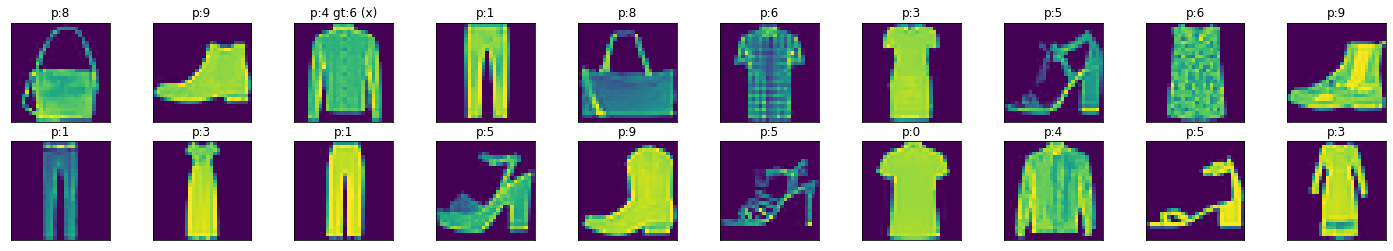

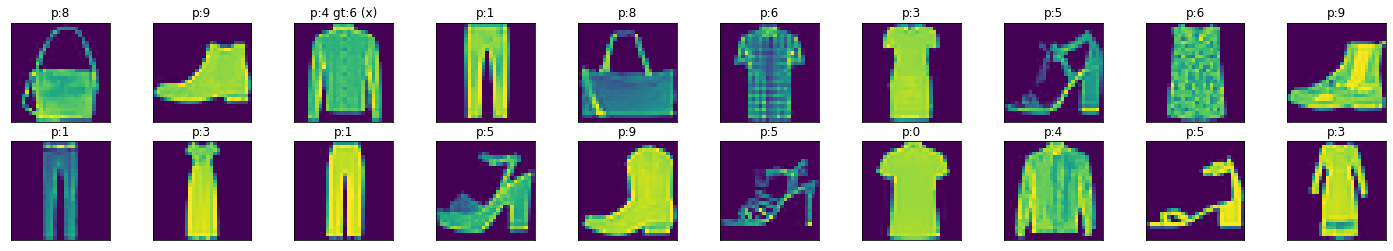

In [17]:
# Visualize some training data
# obtain one batch of training images
dataiter = iter( test_loader )
images_tensor, labels = dataiter.next()
images = images_tensor.numpy() # convert images to numpy for display

print(f'\nimages[0,0,0,0] = {images[0,0,0,0]}\n')
print(f'\nimages[0].mean() = {images[0].mean()}\n')

# Prediction by model, in batch
preds_vit = get_prediction(model_vit, images_tensor)
preds_cnn = get_prediction(model_cnn, images_tensor)

# print(f'{preds_vit = }')
# print(f'{preds_cnn = }')


# plot the first 20 images in the batch, along with the corresponding labels and predictions
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(images[idx], (1, 2, 0))) # (c,h,w) --> (h,w,c)
#     ax.set_title(f'p:{preds[idx]}' + (f' gt:{labels[idx]} (x)' if preds[idx]!=labels[idx] else ''))

plot_image_tiles(images, preds_vit, labels)
plot_image_tiles(images, preds_cnn, labels)

## Calculate the Model Size